In [2]:
import numpy as np
import tbparse as tb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp

sns.set_theme()

# Table Results

In [2]:
#Three sig figs
map = lambda x: np.format_float_positional(x, precision=3, unique=False, fractional=False)

#Extract tb logs
dfs = []
for dataset in ["ignition/", "neuron_transport/"]:#, "channel_flow"]:
    log_dir = "lightning_logs/"+dataset
    experiments = ["hnet_offline_full", "hnet_offline_subsample", "hnet_offline_fjlt", "hnet_online_subsample", "hnet_online_fjlt"]
    
    df = pd.DataFrame(columns=["metric"]+experiments)
    df["metric"] = ["Mean PSNR", "Std PSNR", "Mean RFE", "Std RFE"]
    
    for i, experiment in enumerate(experiments):
        reader = tb.SummaryReader(log_dir+experiment)
        df_ = reader.scalars
        df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]
        
        df.loc[0,experiment] = map(np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"]))
        df.loc[1,experiment] = map(np.std(df_[df_["tag"] == "real_test_avg_PSNR"]["value"]))
        df.loc[2,experiment] = map(np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100)
        df.loc[3,experiment] = map(np.std(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100)

    dfs.append(df)

In [3]:
print("Ignition...")
dfs[0]

Ignition...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,41.6,37.6,37.1,39.8,41.7
1,Std PSNR,0.624,0.589,0.919,2.06,1.18
2,Mean RFE,2.17,3.96,3.87,4.83,2.64
3,Std RFE,0.193,0.316,0.492,2.66,0.852


In [4]:
print("Neuron Transport...")
dfs[1]

Neuron Transport...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,60.4,37.0,48.8,46.0,58.2
1,Std PSNR,0.362,0.858,6.46,1.62,0.819
2,Mean RFE,0.566,7.76,2.88,3.95,0.754
3,Std RFE,0.051,0.762,2.28,0.519,0.0959


In [ ]:
print("Channel Flow...")
dfs[0]

# Neuron Transport: Performance v Sketch Size
Fixed compression rate with varying sketch sizes.

In [41]:
#Extract tb logs
log_dir = "lightning_logs/neuron_transport/"
experiments = [f"hnet_online_fjlt_%_{i}" for i in range(0,4)]
experiments.append("hnet_online_fjlt")

# df = pd.DataFrame(columns=["Sample Factor", "PSNR", "RFE"])
sample_factors = np.linspace(0.001, 0.01, 5)*100
dfs = []

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    PSNR = df_[df_["tag"] == "real_test_avg_PSNR"]["value"]
    RFE = df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100

    dfs.append(pd.DataFrame({"Sample Factor": sample_factors[i], "PSNR": PSNR.to_numpy(), "RFE": RFE.to_numpy()}))

df = pd.concat(dfs, ignore_index=True)

In [43]:
df

,Sample Factor,PSNR,RFE
0,0.100,52.073406,2.824103
1,0.100,52.260994,2.955901
2,0.100,52.018097,2.994268
3,0.100,52.266544,3.029322
4,0.100,51.839809,2.749467
5,0.325,55.231533,2.012891
6,0.325,55.222870,1.789363
7,0.325,56.763950,1.389776
8,0.325,54.764339,2.135794
9,0.325,54.551746,1.836249


In [28]:
#Get offline baseline
df_ = tb.SummaryReader(log_dir+"hnet_offline_full").scalars
df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

mean_PSNR = np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"])
mean_RFE = np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"]*100)

In [30]:
mean_RFE

0.566486231982708

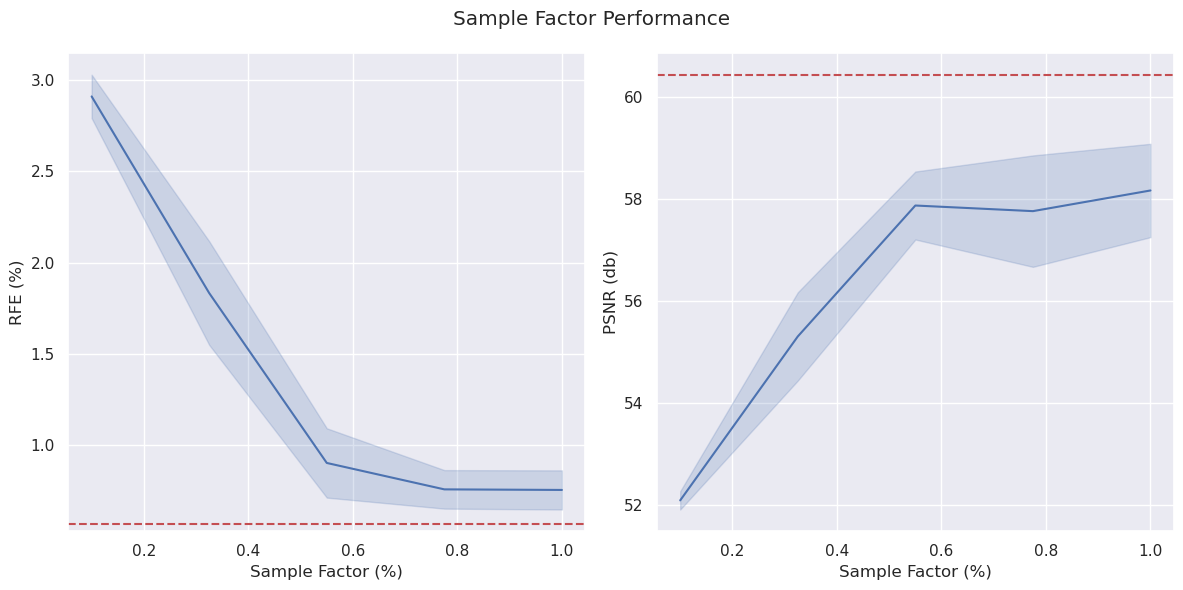

In [44]:
#Plot
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.lineplot(data=df, x="Sample Factor", y="RFE", ax=ax[0], errorbar="sd")
ax[0].axhline(mean_RFE, c="r", ls="--")
ax[0].set_xlabel("Sample Factor (%)")
ax[0].set_ylabel("RFE (%)")

sns.lineplot(data=df, x="Sample Factor", y="PSNR", ax=ax[1], errorbar="sd")
ax[1].axhline(mean_PSNR, c="r", ls="--")
ax[1].set_xlabel("Sample Factor (%)")
ax[1].set_ylabel("PSNR (db)")

fig.suptitle("Sample Factor Performance")

fig.tight_layout()

In [45]:
fig.savefig("misc/figures/sample-factor-performance.png")

# Neuron Transport: Performance v Full Buffer Size
Fixed sketch size with varying full buffer sizes.

In [37]:
#Extract tb logs
log_dir = "lightning_logs/neuron_transport/"
experiments = ["hnet_online_fjlt"]
experiments.extend([f"hnet_online_fjlt_s_{i}" for i in range(0,-1,-1)])

df = pd.DataFrame(columns=["Full Buffer Size", "RFE", "PSNR"])
sizes = np.linspace(1, 25, 5)

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

    df.loc[i] = [sizes[i], df_.loc[1,"value"], df_.loc[0,"value"]]

In [38]:
df

,Full Buffer Size,RFE,PSNR
0,1.0,0.008355,58.017242
1,7.0,0.012121,59.040443


In [39]:
#Get offline baseline
df_ = tb.SummaryReader(log_dir+"hnet_offline_full").scalars
df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

df_offline = pd.DataFrame(columns=["RFE", "PSNR"])
df_offline.loc[0] = [df_.loc[1,"value"], df_.loc[0,"value"]]

In [40]:
df

,Full Buffer Size,RFE,PSNR
0,1.0,0.008355,58.017242
1,7.0,0.012121,59.040443


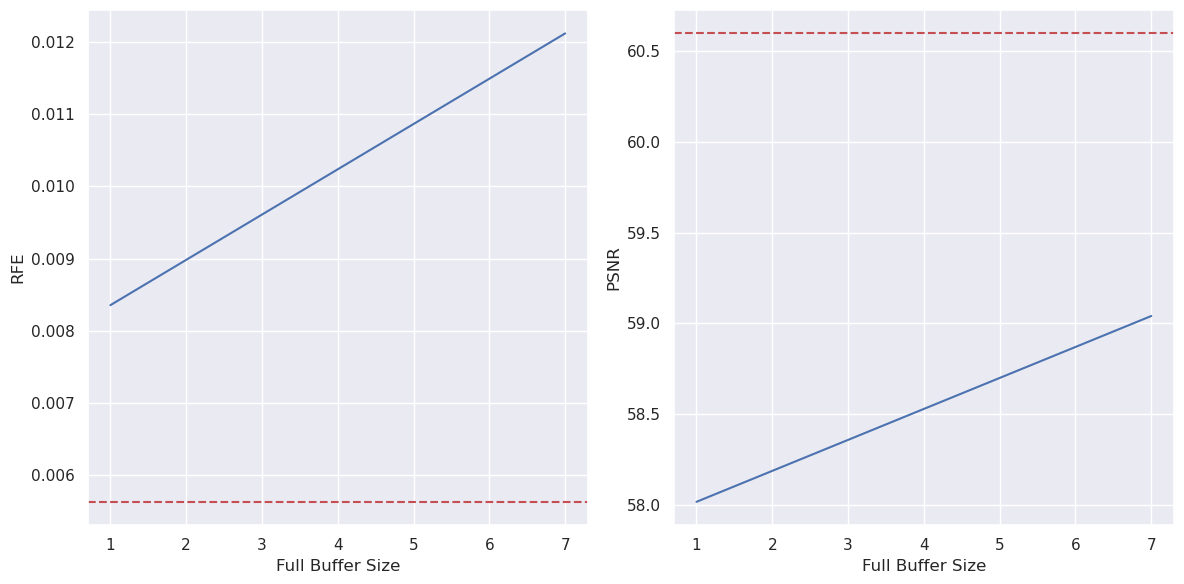

In [49]:
#Plot
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.lineplot(data=df, x="Full Buffer Size", y="RFE", ax=ax[0])
ax[0].axhline(df_offline["RFE"][0], c="r", ls="--")

sns.lineplot(data=df, x="Full Buffer Size", y="PSNR", ax=ax[1])
ax[1].axhline(df_offline["PSNR"][0], c="r", ls="--")

fig.tight_layout()

# Ignition Plots

In [2]:
#Load Data
frame = 15

raw = np.load("data/ignition/features.npy")[frame,:,1].reshape(50,50)
r_baseline = np.load("lightning_logs/ignition/hnet_offline_full/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)
r_fjlt = np.load("lightning_logs/ignition/hnet_online_fjlt/version_3/reconstruction.npy")[frame,:,1].reshape(50,50)

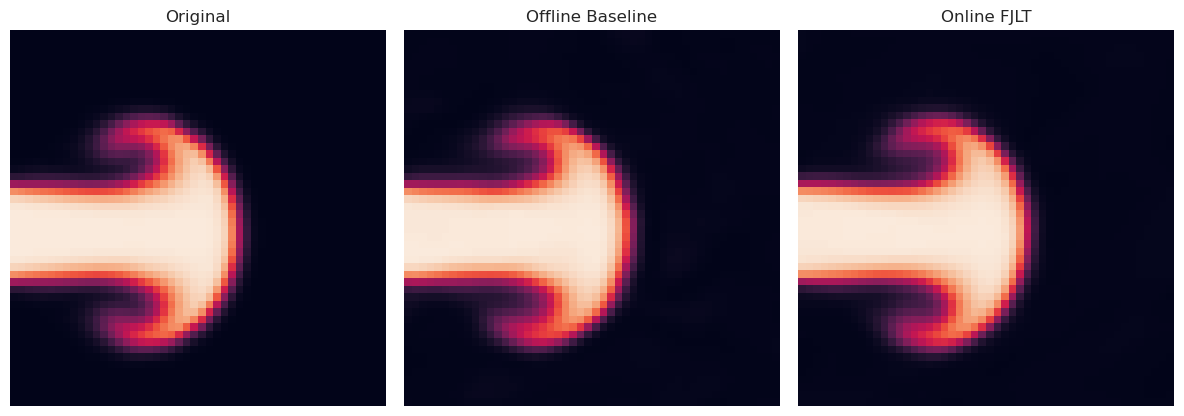

In [3]:
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].imshow(raw)
axs[0].set_title("Original")

axs[1].imshow(r_baseline)
axs[1].set_title("Offline Baseline")

axs[2].imshow(r_fjlt)
axs[2].set_title("Online FJLT")

for ax in axs:
    ax.grid(False)
    ax.axis(False)

fig.tight_layout()

In [5]:
fig.savefig("misc/figures/ignition-comparison.png",bbox_inches='tight')

In [3]:
#Load Data
df = tb.SummaryReader("lightning_logs/ignition/hnet_online_fjlt/version_3/events.out.tfevents.1726546773.bgpu-biokem2.rc.int.colorado.edu.780349.0").scalars
full = df[df['tag']=='train_loss_1']['value'].to_numpy()
sketch = df[df['tag']=='train_loss_2']['value'].to_numpy()

full = full[499::500]
sketch = sketch[499::500]

#Testing error
raw = np.load("data/ignition/features.npy")[:,:,[1]]
r_fjlt = np.load("lightning_logs/ignition/hnet_online_fjlt/version_3/reconstruction.npy")[:,:,[1]]

n = np.sum((raw-r_fjlt)**2, axis=(1,2))
d = np.sum((raw)**2, axis=(1,2))

test = np.sqrt(n/d)

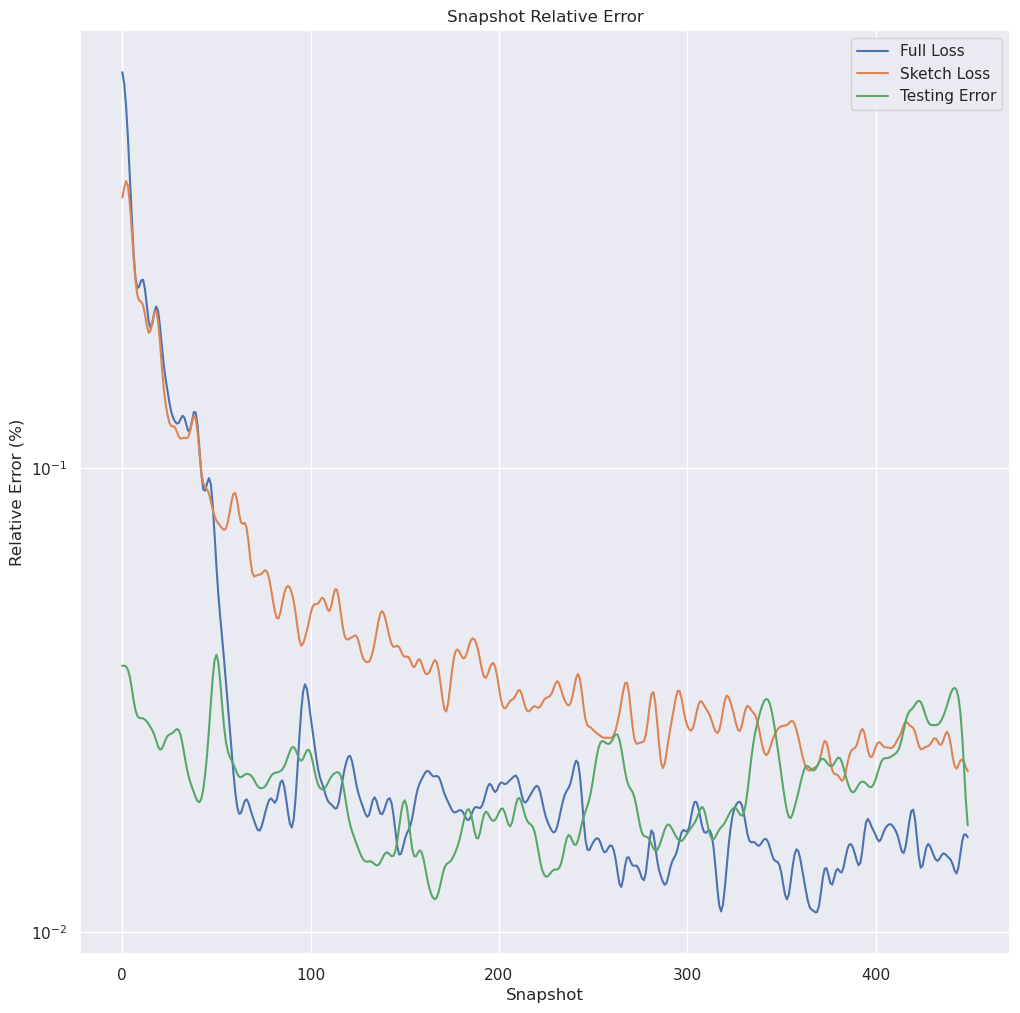

In [6]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

# ax.semilogy(full)
# ax.semilogy(sketch)
# ax.semilogy(test)

ax.semilogy(scp.ndimage.gaussian_filter(full, 2.0))
ax.semilogy(scp.ndimage.gaussian_filter(sketch, 2.0))
ax.semilogy(scp.ndimage.gaussian_filter(test, 2.0))

ax.set_title("Snapshot Relative Error")
ax.set_xlabel("Snapshot")
ax.set_ylabel("Relative Error (%)")
ax.legend(["Full Loss", "Sketch Loss", "Testing Error"])

In [16]:
fig.savefig("misc/figures/ignition-r3error.png",bbox_inches="tight")

# Channel Flow

In [6]:
#Load Data
frame = 249
z_slice = 31

raw = np.load("data/channel_flow/features_64_500.npy")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]
# r_baseline = np.load("")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]
# r_fjlt = np.load("")[frame,:,:].reshape(64,64,64,-1)[:,:,z_slice,:]

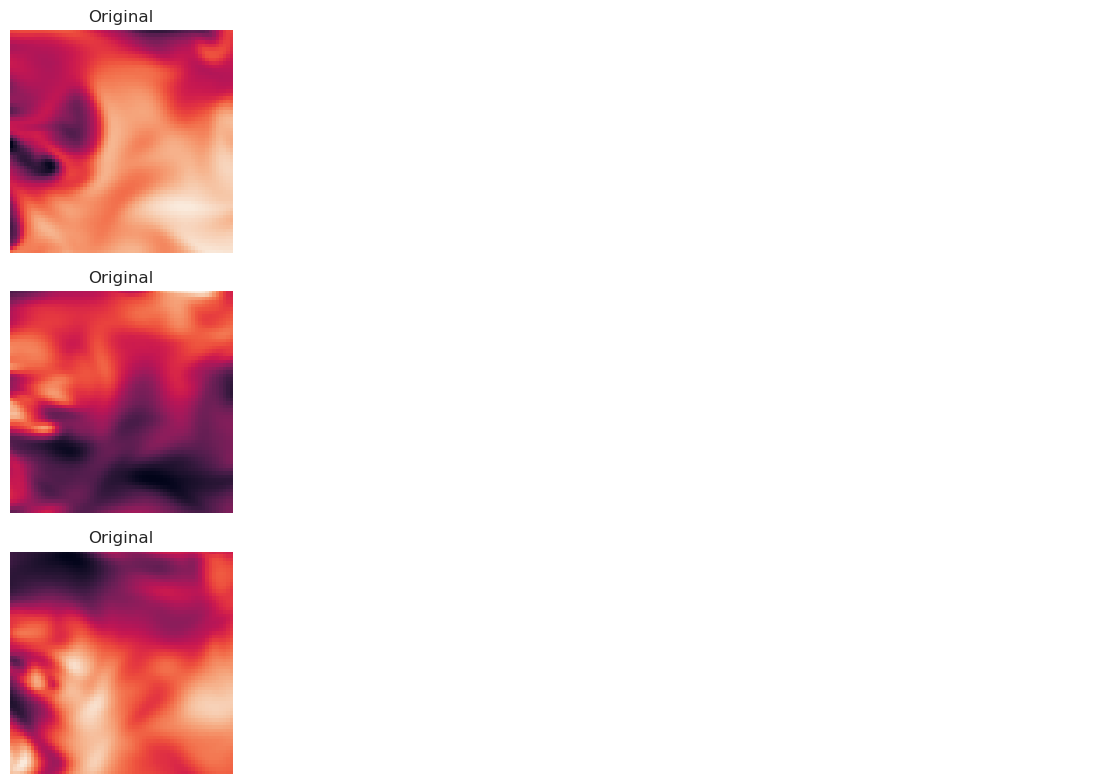

In [7]:
fig, axs = plt.subplots(3,3,figsize=(12,8))

for i in range(3):
    axs[i,0].imshow(raw[:,:,i])
    axs[i,0].set_title("Original")
    
    # axs[i,1].imshow(r_fjlt[:,:,i])
    # axs[i,1].set_title("Offline Baseline")
    
    # axs[i,2].imshow(raw_baseline[:,:,i])
    # axs[i,2].set_title("Online FJLT")

for ax in np.ravel(axs):
    ax.grid(False)
    ax.axis(False)

fig.tight_layout()

In [8]:
fig.savefig("misc/figures/channel-flow-comparison.png",bbox_inches='tight')